<a href="https://colab.research.google.com/github/Romanchenko-RS/ML/blob/main/%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D1%87%D0%B5%D0%BD%D0%BA%D0%BE_%D0%A0_%D0%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ текста**

**Установка библиотеки**

In [ ]:
pip install hmmlearn

**Импорт необходимых библиотек**

In [ ]:
import os
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from hmmlearn import hmm
from sklearn.metrics import mean_squared_error

**Получение данных**

In [ ]:
repo_url = 'https://raw.githubusercontent.com/netology-code/ds3-spring-2018/master/7.%20Time_series/7.4/war_and_peace/'
file_names = ['tom_1.txt', 'tom_2.txt', 'tom_3.txt', 'tom_4.txt']
output_file = 'output.txt'

**Необходимые функции**

In [ ]:
# Скачиваем файлы и собираем текст
def download_files(repo_url, file_names):
    full_text = ""
    for file_name in file_names:
        url = f"{repo_url}{file_name}"
        response = requests.get(url)
        if response.status_code == 200:
            full_text += response.text + "\n"
        else:
            print(f"Не удалось загрузить файл {file_name}. Статус: {response.status_code}")
    return full_text

In [ ]:
# Очищаем текст
def clean_text(text):
    # Удаляем недопустимые символы, оставляя только буквы и пробелы
    cleaned_text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
    # Удаляем лишние пробелы, если они есть
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text.strip()

In [ ]:
# Строим матрицу переходных вероятностей
def build_transition_matrix(text):
    n = len(text)
    transitions = defaultdict(lambda: defaultdict(int))

    for i in range(n - 1):  # Переходы между текущим и следующим символами
        transitions[text[i]][text[i + 1]] += 1

    # Преобразование в вероятности
    transition_matrix = defaultdict(dict)

    for current in transitions:
        total = sum(transitions[current].values())
        for next_char in transitions[current]:
            transition_matrix[current][next_char] = transitions[current][next_char] / total

    return transition_matrix


In [ ]:
# Визуализация матрицы
def visualize_matrix(transition_matrix):
    characters = sorted(transition_matrix.keys())
    matrix = np.zeros((len(characters), len(characters)))

    for i, char1 in enumerate(characters):
        for j, char2 in enumerate(characters):
            matrix[i, j] = transition_matrix[char1].get(char2, 0)

    plt.figure(figsize=(16, 12))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.xticks(ticks=range(len(characters)), labels=characters)
    plt.yticks(ticks=range(len(characters)), labels=characters)
    plt.colorbar()
    plt.title('Матрица переходных вероятностей')
    plt.show()


In [ ]:
# Вероятность строки из 4 символов, начинающейся на "п" и заканчивающейся на "р"
# Првоерим только для строчных букв, т.к. слово не может заканчиваться прописной буквой
def probability_of_substring(transition_matrix):
    count = 0
    for char in transition_matrix:
        if char == 'п':
            for next_char in transition_matrix[char]:
                for next_next_char in transition_matrix[next_char]:
                    for final_char in transition_matrix[next_next_char]:
                        if final_char == 'р':
                            count += transition_matrix[char][next_char] * transition_matrix[next_char][next_next_char] * transition_matrix[next_next_char][final_char]
    return count

In [ ]:
# Генерация слова
def generate_word(transition_matrix, start_char, length):
    word = start_char
    current_char = start_char
    for _ in range(length - 1):  # длина = 8, уже есть 1 символ
        next_chars = list(transition_matrix.get(current_char, {}).keys())
        if not next_chars:
            break
        current_char = np.random.choice(next_chars, p=list(transition_matrix[current_char].values()))
        word += current_char
    return word

**Основной код**

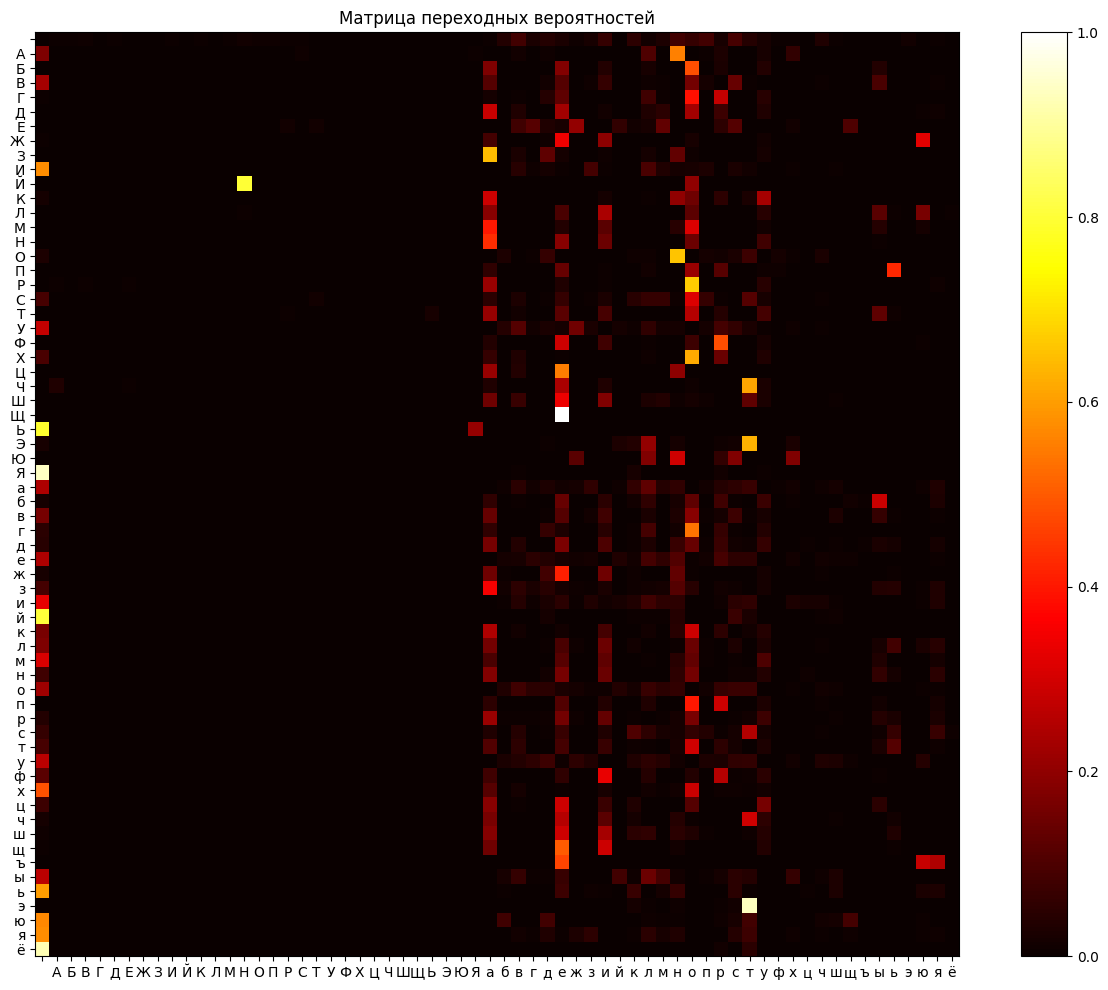

Вероятность встретить строку: 0.032001
Сгенерированное слово: Бориненг


In [ ]:
full_text = download_files(repo_url, file_names)
cleaned_text = clean_text(full_text)
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(cleaned_text)

transition_matrix = build_transition_matrix(cleaned_text)
visualize_matrix(transition_matrix)
prob = probability_of_substring(transition_matrix)
generated_word = generate_word(transition_matrix, 'Б', 8)

print(f"Вероятность встретить строку: {prob:.6f}")
print(f"Сгенерированное слово: {generated_word}")

**Выводы**

Получили матрицу переходных вероятностей для большого текста, собранного из 4-х текстовых файлов.

При помощи данной марицы научились предсказывать вероятность получить строку определённой длины и по определённым правилам, а также генерировать случайные слова (лучше сказать токены) фиксированной длины.

# **Анализ через HMM**

In [ ]:
# Загрузка данных
url = "https://raw.githubusercontent.com/RomanchenkoRS/ML/main/time%20series/weekly-closings-of-the-dowjones-.csv"
data = pd.read_csv(url)

In [ ]:
# Преобразование данных
data['Week'] = pd.to_datetime(data['Week'] + '-1', format='%Y-W%W-%w')  # Преобразуем недели в даты
data.set_index('Week', inplace=True)
close_prices = data['Close'].values

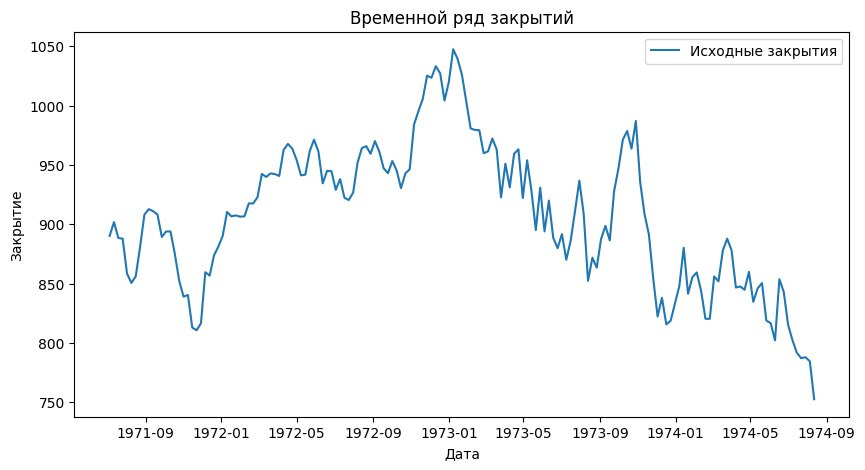

In [ ]:
# Визуализация исходного временного ряда
plt.figure(figsize=(10, 5))
plt.plot(data.index, close_prices, label="Исходные закрытия")
plt.title("Временной ряд закрытий")
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.legend()
plt.show()

In [ ]:
# Подготовка данных для HMM
# hmmlearn ждет, чтобы данные имели форму (n_samples, n_features)
X = close_prices.reshape(-1, 1)

In [ ]:
# Оценка модели HMM для разного количества компонентов
scores = []
components_range = range(1, 15)

for n_components in components_range:
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
    model.fit(X)  # Обучение модели
    score = model.score(X)  # Получение score (логарифмическое правдоподобие)
    scores.append(score)
    print(f"Компоненты: {n_components}, Score: {score}")

Компоненты: 1, Score: -894.2620483582104
Компоненты: 2, Score: -894.2619612174508
Компоненты: 3, Score: -820.5688812377734
Компоненты: 4, Score: -820.5471103716733
Компоненты: 5, Score: -786.5725841692653
Компоненты: 6, Score: -726.6539280582718
Компоненты: 7, Score: -758.384315324905
Компоненты: 8, Score: -716.665457831776
Компоненты: 9, Score: -709.4239291381552
Компоненты: 10, Score: -747.5591172760347


Компоненты: 11, Score: -712.543790564691


Компоненты: 12, Score: -694.6607461591226


Компоненты: 13, Score: -703.0641212728426
Компоненты: 14, Score: -714.9733199727559


Используя большое количество компонент, возможно получить переобучения. Примем кол-во компонентов равное 6.

In [ ]:
# Обучение модели с оптимальным количеством компонентов
optimal_n_components = 6
model = hmm.GaussianHMM(n_components=optimal_n_components, covariance_type="full", n_iter=1000)
model.fit(X)

GaussianHMM(covariance_type='full', n_components=6, n_iter=1000)

In [ ]:
# Предсказание
hidden_states = model.predict(X)

In [ ]:
# Восстановление временного ряда на основе скрытых состояний
predicted_prices = model.means_[hidden_states.flatten()]

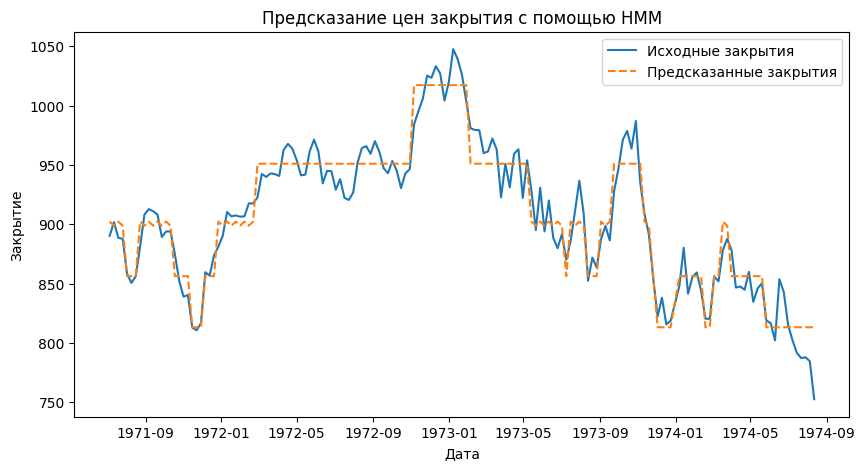

In [ ]:
# Визуализация предсказанного временного ряда
plt.figure(figsize=(10, 5))
plt.plot(data.index, close_prices, label="Исходные закрытия")
plt.plot(data.index, predicted_prices, label="Предсказанные закрытия", linestyle='--')
plt.title("Предсказание цен закрытия с помощью HMM")
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.legend()
plt.show()

Получаем довольно неплохое предсказание

In [ ]:
# Наивный прогноз на основе средних значений каждой компоненты
naive_forecast = np.zeros_like(close_prices)
for state in range(optimal_n_components):
    condition = (hidden_states == state)
    naive_forecast[condition] = np.mean(model.means_[state])  # Заполнение средним значением для каждого состояния

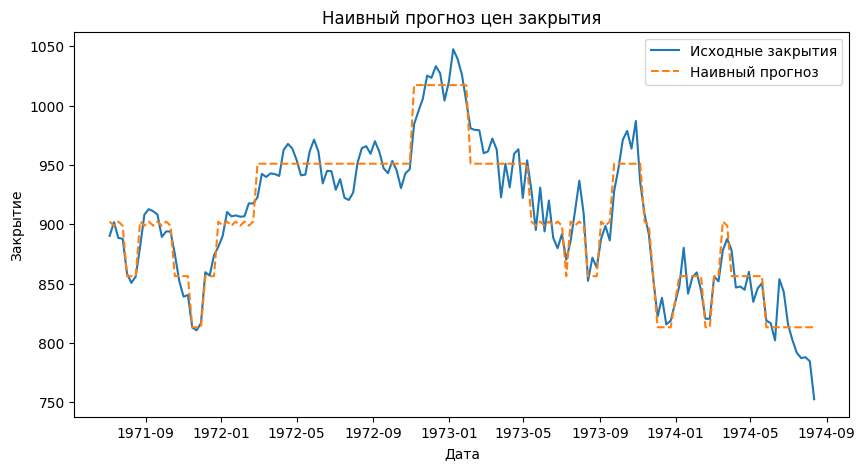

In [ ]:
# Визуализация наивного прогноза
plt.figure(figsize=(10, 5))
plt.plot(data.index, close_prices, label="Исходные закрытия")
plt.plot(data.index, naive_forecast, label="Наивный прогноз", linestyle='--')
plt.title("Наивный прогноз цен закрытия")
plt.xlabel("Дата")
plt.ylabel("Закрытие")
plt.legend()
plt.show()

In [ ]:
# Сравнение значений наивного прогноза с прогнозами HMM
rmse_hmm = np.sqrt(mean_squared_error(close_prices, predicted_prices))
rmse_naive = np.sqrt(mean_squared_error(close_prices, naive_forecast))

print(f"RMSE для прогнозов HMM: {rmse_hmm}")
print(f"RMSE для наивного прогноза: {rmse_naive}")

RMSE для прогнозов HMM: 16.28506070261815
RMSE для наивного прогноза: 16.28506070261815


**Выводы**

Удалось подобрать оптимальное значение компонентов, основываясь на метрику score (логарифмическое правдоподобие), которое показало высокую схожесть с исходным временным рядом.

Удалось реализовать наивный прогноз, который совпал с предсказаниями модели HMM.